__ Для опытов над моделями удобно использовать библиотеку для pytorch - torchvision __

In [77]:
import torch
import torch.nn as nn
import torchvision.models as models
from IPython.core.display import display, HTML, Markdown
import math
from operator import mul
from functools import reduce

In [84]:
# Вспомогательная функция для печати
def html_print(List):
    out = ''
    
    for Text, Data in List:
        f_str = '{1:,}' if type(Data) == int else '{1}'
        if len(out) > 0: out += ', ' 
        out += ("<font size=6>{0}</font> <font color=blue size=5> "+f_str).format(Text, Data) + "</font>"
    display(HTML(out))
    
def display_gif(fn):
    from IPython import display
    return display.HTML('<img src="{}">'.format(fn))
    
def print_size(Text, Size):
    l = "%d"%Size[0]
    for s in Size[1:]:
        l += 'x%d'%s
    html_print([(Text,l)])
    
def print_sizes(Text, Sizes):
    size = '' 
    for s in Sizes:
        l = "%d"%s[0]
        for ss in s[1:]:
            l += 'x%d'%ss
            
        if len(size) > 0: size += ' + '
        size += l
        
    html_print([(Text,size)])

# Сверточные сети

## Откуда пошли сверточные сети

# 1958 - Hubel and Wiesel

<img src="./img/7.jpg" width=500>

<img src="./img/9.png" width=500>

- **Simple cells**: дают ответ на ориентацию света 
- **Complex cells**: ответ ориентацию света и движение 
- **Hypercomplex cells**: ответ на движение с конечной точкой
<img src="./img/cat_exp.png" width=500>

### Примеры фильтров сверточных слоев:
Детектируют края, направления краев

<img src="./img/slide-18.jpg" width=700>

# 1998 LeNet-5 (LeCun et.al.)

<img src="./img/12.png" width=700>


## Что такое сверточный слой 
Перейдем в презентацию

## Небучаемая 2d свертка в PyTorch
```python
class torch.nn.functional.conv2d(
     x, # входное изображение
     weight, # ядро фильтра
     bias # смещение
    stride=1,     # Шаг свертки
    padding=0,    # Поля - сколько прибавлять по краям     
)
```
## Обучаемая 2d свертка в PyTorch

```python
class torch.nn.Conv2d(
    in_channels,  # Число каналов на входе
    out_channels, # Число каналов на выходе
    kernel_size,  # Размер ядра свертки
    stride=1,     # Шаг свертки
    padding=0,    # Сколько прибавлять по краям
    dilation=1, groups=1, bias=True) # Параметры не интересные в нашем курсе
```

- Вход: $(N, C_{in}, H_{in}, W_{in})$
- Выход: $(N, C_{out}, H_{out}, W_{out})$
- Есть варинаты 1d (для звука, например) и 3d (для объемных томограмм например)


## Какие еще есть параметры у свертки:


### Stride
<img src="./img/22.gif" width=300>

### Padding
<img src="./img/23.gif" width=400>

### Dilation
<img src="./gifs/dilation.gif" width=400>


## Пример работы свертки:

<img src="./img/18.jpg">

<img src="./img/19.png">



### Свернем кота
### Грузим картинку

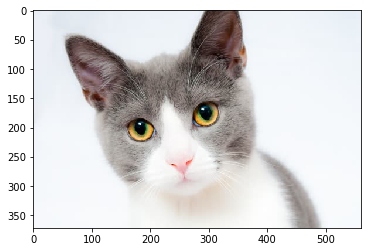

In [19]:
import torch
import torchvision as tv
import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image
cat_convolve= Image.open('./img/cat_convolve.jpg')
plt.imshow(cat_convolve)

### Превращаем кота в тензор

In [27]:
cat_tensor = tv.transforms.ToTensor()(cat_convolve).unsqueeze(0)
print (cat_tensor.size())

torch.Size([1, 3, 372, 560])


### Создаем фильтры ядер

In [57]:
import torch.nn.functional as F

#Число каналов в изображении
channels = cat_tensor.size(1)

# Ядро Собеля для выделения границ
Iy = [[ 1, 2, 1],
        [ 0, 0, 0],
        [-1,-2,-1]]

Ix = [[-1, 0, 1],
        [-2, 0, 2],
        [-1, 0, 1]]

# Эквивалентное преобразование
Eq = [[1]]

# Размытие изображения
Mean = [[1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1]]
    

Iy = torch.Tensor([ [Iy] * channels ])
Ix = torch.Tensor([ [Ix] * channels])
Mean = torch.Tensor([ [Mean] * channels])
Eq = torch.Tensor([ [Eq] * channels])

kernels = {
    'Sobel, y' : Iy,
    'Sobel, x' : Ix,
    'Mean' : Mean,
    'Eq' : Eq
}

def compute_gradient(image, kernel):
    return F.conv2d(input=image, weight=kernel, groups=image.size(0)) 

In [66]:
sobel_y = compute_gradient(cat_tensor, kernels['Sobel, y'])
sobel_y = sobel_y.squeeze(0).squeeze(0)

sobel_x = compute_gradient(cat_tensor, kernels['Sobel, x'])
sobel_x = sobel_x.squeeze(0).squeeze(0)

In [67]:
sobel_y[sobel_y >= 0.5] = 1  # бустим границы
sobel_y[sobel_y < 0.5] = 0

sobel_x[sobel_x >= 0.5] = 1  
sobel_x[sobel_x < 0.5] = 0

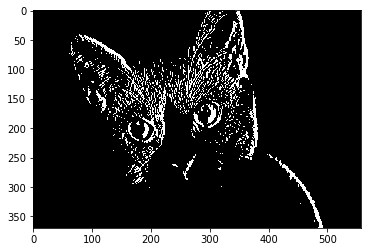

In [69]:
plt.imshow(sobel_x.numpy(), cmap='gray')

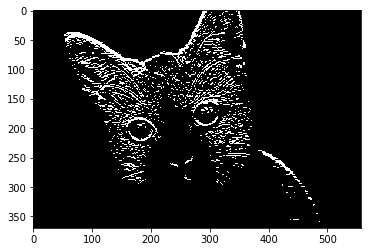

In [70]:
plt.imshow(sobel_y.numpy(), cmap='gray')

In [71]:
equal = compute_gradient(cat_tensor, kernels['Eq'])
equal = equal.squeeze(0).squeeze(0)

mean = compute_gradient(cat_tensor, kernels['Mean'])
mean = mean.squeeze(0).squeeze(0)

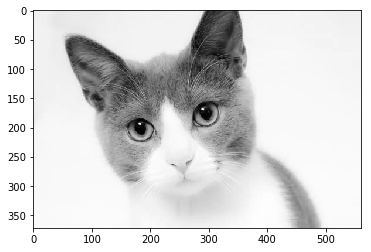

In [72]:
plt.imshow(equal.numpy(), cmap='gray')

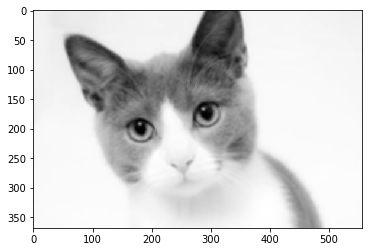

In [73]:
plt.imshow(mean.numpy(), cmap='gray')

### Конволюционная сеть - последовательность сверточных слоев и нелинейных функций активации
- Для извлечения более информативных признаков из картинок нужно увеличивать количество карт признаков
- Это приводит к увеличению объема занимаемой памяти.
- Можно уменьшать размер одной карты признаков, т.е. делать понижающую свертку downsampling, в тоже время увеличивая количество карт признаков

# Pooling
* Average polling - был в примере с котэ проходим по изображению сверткой  $ \begin{bmatrix}
    1 & 1 \\
    1 & 1
\end{bmatrix}$ с шагом > 1 и результ усредняем

* Max Pooling - выбирается максимальное значение

<img src="./img/26.jpg" width=400>
<img src="./img/27.jpg" width=400>


```python
# class pytorch
# pooling среднего
class torch.nn.AvgPool1d(
# pooling максимального значения
class torch.nn.MaxPool2d(kernel_size,  # размер ядра
                         stride=None,  # шаг
                         padding=0,    # поля
```

### Average & Max Pooling не диффирецируемы и не имеют обучаемых параметров
- Можно использовать вместо свертку с обучаемыми параметрами



# Augmentation
Если данных мало, то велика вероятность, что сеть переобучится. Наряду с такими подходами как dropout, batch normalizatio можно увеличить разнообразие данных путем внесения в них искуственных изменений, моделируя возможное распределение в данных.
1. Шум $\large x = x + Noise(~N(0, 1)) $
2. Повороты входного изображения
3. Сдвиг изображения
4. Crop - обрезание изображения
5. Увеличение изображения
6. Зеркальное отражение
7. Цветовой микс
8. Насыщение цветового баланса
9. Изменение яркости
<img src="./img/32.png" >
<img src="./img/41.png" >

```python
# определены основные трансформации
import torchvision.transforms as transform 
```

# <font size=10 color=blue>LeNet</font>
### _ [LeCun et al., 1998] _
---
![LeNet](./img/lenet.png)

<font size=5>
* Конволюции:  фильтры 5x5, страйд 1 <br/><br/>
* Сабсамплинг aka пулиг:  фильтры 2x2 , страйд 2 <br/><br/>
* Архитектура: [CONV-POOL-CONV-POOL-FC-FC]

</font>
---

___


# <font size=10 color=blue>AlexNet</font> 
### _ [Krizhevsky et al. 2012] _

![AlexNet картинка из статьи](img/alexnet.png)

<font size='5'> В 2012 году решение на основе AlexNet выиграло соревнование ILSVRC'12 (ImageNet)</font>

# <font color=blue size=8>AlexNet - архитектура </font>

In [5]:
alex_net = models.AlexNet()
alex_net

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p=0.5)
    (4): Linear(in_features=4096,

# <font color=blue size=10> AlexNet - первый слой</font>
Через свойство _ features _ получаем доступ к конволюционным слоям. Через свойство _ classifier _ доступ к FC слоям


In [85]:
CONV1 = alex_net.features[0]
html_print([( "Свертка первого слоя:  ", CONV1)])

### Размер входного изображения <font color=blue>224x224</font>
Количество каналов изображение можно получить через in_channels

In [8]:
html_print([("Количество каналов изображения: ", CONV1.in_channels)] )

---
### Размер конволюции:
<br>Получаем размер конволюции через свойства
* kernel_size - размер ядра
* stride      - шаг
* out_channels - количество выходных каналов
* padding      - паддинг

In [88]:
html_print([( 'Размер ядра: ', "%d"%CONV1.kernel_size[0] + "x%d"%CONV1.kernel_size[1] ),
            ('Выходных панелей: ', "%d"%CONV1.out_channels ),
            ("Шаг: ", "%d"%CONV1.stride[0] + "x%d"%CONV1.stride[1] ),
            ("=> Итого: ","{0}x{1}x{2}, stride: {3}".format(CONV1.out_channels,
               CONV1.kernel_size[0], CONV1.kernel_size[1], CONV1.stride[0]))])


<font color=red size=6>В: Какой размер выхода?</font>
<br>Если мы знаем, что: <br>
$$H_{out} = floor((H_{in}  + 2 * padding[0] - kernel\_size[0]) / stride[0] + 1)$$
$$W_{out} = floor((W_{in}  + 2 * padding[1] - kernel\_size[1]) / stride[1] + 1)$$

In [87]:
Hout = math.floor((224+2*CONV1.padding[0]-CONV1.kernel_size[0])/CONV1.stride[0]+1)
Wout = math.floor((224+2*CONV1.padding[1]-CONV1.kernel_size[1])/CONV1.stride[1]+1)
display(Markdown( "$$ H_{out}=%d $$ "%Hout ))
display(Markdown( "$$ W_{out}=%d $$ "%Wout ))

$$ H_{out}=55 $$ 

$$ W_{out}=55 $$ 

Что получим:

In [89]:
html_print([( "Размер выходного слоя: ", "{0}x{1}x{2}".format(64,55,55)),
            ("=> Размер выходного слоя в байтах: ", "{0}".format(64*55*55*4))])

<font color=red size=6>В: Какое количество параметров слоя?</font>

In [90]:
html_print([("Размер тензора параметров: ", "{0}x{1}x{2}x{3}".format(3,11,11,64)),
            ("Количество параметров: ", "{0}".format(3*11*11*64))])

In [91]:
html_print([("Проверь себя - количество параметров: ", "{0}".format(reduce(mul, CONV1.weight.size(), 1)))])

___
# <font color=blue size=10> AlexNet - второй слой</font> 


In [92]:
POOL1=alex_net.features[2]
html_print([("Пулинг: ", POOL1)])

<font color=red size=6>Формула для рассчета выхода пулинг слоя</font>
$$H_{out} = floor((H_{in}  + 2 * padding[0] - dilation[0] * (kernel\_size[0] - 1) - 1) / stride[0] + 1)$$
$$W_{out} = floor((W_{in}  + 2 * padding[1] - dilation[1] * (kernel\_size[1] - 1) - 1) / stride[1] + 1)$$

Размерность выхода второго слоя:

In [93]:
# генерируем тензор по размеру выхода первого слоя, пропускаем его через второй  слой
POOL1_IN = Variable(torch.rand(64, 55, 55))
POOL1_OUT = POOL1(POOL1_IN)
print_size("Вход пулинг слоя: ", POOL1_IN.size() )
print_size("Выход пулинг слоя: ", POOL1_OUT.size() )

<font color=red size=6>В: Количество параметров пулинг слоя?</font>

In [16]:
html_print([("Параметров в пулинг слое: ", "{0}".format(0))])

# <font size=10 color=blue>AlexNet</font> 
### _ [Krizhevsky et al. 2012] _

### _ Полная архитектура: _
<div style='font-size:20px'>
<pre>
[227x227x3] INPUT 
[55x55x96]  <font color=red>CONV1: </font> 96x11x11 filters at stride 4, pad 0 
[27x27x96]  <font color=blue>MAX POOL1:</font> 3x3 filters at stride 2
[27x27x96]  <font color=green>NORM1:</font> Normalization layer 
[27x27x256] <font color=red>CONV2:</font> 256 5x5 filters at stride 1, pad 2 
[13x13x256] <font color=blue>MAX POOL2:</font> 3x3 filters at stride 2 
[13x13x256] <font color=green>NORM2:</font> Normalization layer 
[13x13x384] <font color=red>CONV3:</font> 384 3x3 filters at stride 1, pad 1 
[13x13x384] <font color=red>CONV4:</font> 384 3x3 filters at stride 1, pad 1 
[13x13x256] <font color=red>CONV5:</font> 256 3x3 filters at stride 1, pad 1 
[6x6x256]   <font color=blue>MAX POOL3:</font> 3x3 filters at stride 2 
[4096] <font color=brown>FC6:</font> 4096 neurons 
[4096] <font color=brown>FC7:</font> 4096 neurons 
[1000] <font color=brown>FC8:</font> 1000 neurons (class scores)
</pre>
</div>

### _ Детали: _
- Первое использование ReLU 
- Использование  Norm layers (не прижилось)  
- Data augmentation 
- Dropout 0.5 
- Batch size 128 
- SGD Momentum 0.9 
- Learning rate 1e-2, уменьшали в 10 раз руками, при насыщении
- L2 weight decay 5e-4 
- 7 CNN в ансамбле: 18.2% -> 15.4%


![AlexNet](img/alexnet01.png)

### _ История: _
<div style='font-size:20px; padding:10px; color:blue'>
Тренировали на GTX 580 GPU, память 3 GB .  Сеть разделили на 2 GPU, по половине на нейронов на каждый.
</div>


![AlexNet](./img/alexnet03.png)

<div style='font-size:20px; padding:10px; color:blue'>
CONV1, CONV2, CONV4, CONV5: Соединятся только карты признаков на одной GPU
</div>

![AlexNet](img/alexnet02.png)

<div style='font-size:20px; padding:10px; color:blue'>
CONV3, FC6, FC7, FC8: Соединятся карты признаков с предшествующим слоем между GPU
</div>

# <font size=10 color=blue> Победители ImageNet Large Scale Visual Recognition Challenge (LSVRC) 
</font>
![ImageNet](./img/ImageNetGraph01.png)

# <font size=10 color=blue> LSVRC-2014 </font>
![ImageNet](./img/ImageNetGraph03.png)

# <font size=10 color=blue> VGGNet </font>
### _ [Simonyan and Zisserman, 2014] _
* VGG11
* VGG13
* VGG16
* VGG19

## <font  color=blue> VGG11 + PyTorch </font>

In [94]:
vgg = models.vgg11()
vgg.features

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU(inplace)
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU(inplace)
  (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU(inplace)
  (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (12): ReLU(inplace)
  (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (14): ReLU(inplace)
  (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (16): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17)

In [95]:
vgg.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace)
  (2): Dropout(p=0.5)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace)
  (5): Dropout(p=0.5)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)


 ![VGGNet01](./img/VGG01.png)


 * <font color=red>Меньшие фильтры, Сети глубже </font> 
 <font color=blue>
 * 8 слоев (AlexNet) -> 16 - 19 слоев (VGG16Net)
 * Используем только 3x3 CONV stride 1, pad 1 and  2x2 MAX POOL stride 2
 * 11.7% top 5 error в ILSVRC’13 (ZFNet) -> 7.3% top 5 error в ILSVRC’14
 </font>

<font color=red size=6>
<br>
 В: Зачем использовать небольшие (3x3) фильтры?
</font>


<font color=red size=6>
<br>

 В: Какое эффективное рецептивное поле  у трех конволюционных слоев с конволюцией 3x3 (stride 1)?
 
</font>


![ConvSobel](./img/convSobel.gif)


 * Стэк из трех слоев с конволюциями 3x3 (stride 1)  имеет такое же рецептивное поле как один слой с конволюцией 7x7
 * Глубже, больше нелинейностей
 * Меньше параметров: $$ 3 * (3^2*С^2) $$ vs. $$ 7^2*С^2 $$ где C - количество каналов на слой


In [96]:
# небольшой код по подсчету памяти и количества параметров в сети
MODULES_STAT=[]

def module_forward_hook(module, input, output):
    weight = module.weight.size() if type(module) != torch.nn.modules.MaxPool2d is not None else (0, 0, 0, 0)
    MODULES_STAT.append((module, output.size(), weight))
    
def setup_vgg_hooks(vgg):
    for f in vgg.features: 
        if type(f) == torch.nn.modules.conv.Conv2d or type(f) == torch.nn.modules.MaxPool2d :
            f.register_forward_hook(module_forward_hook)
            
    for f in vgg.classifier:
        if type(f) == torch.nn.modules.Linear:
            f.register_forward_hook(module_forward_hook)
                 
def features_mem_and_params(vgg, input_tenzor):
    out = vgg(input_tenzor)
    input_size = input_tenzor.size()
    total_param= 0
    total_mem =  reduce(mul,(input_size))
    print( "%02d"%(0),'INPUT',"memory", "%dx%dx%d=%d"%(input_size[0], input_size[1], input_size[2], reduce(mul,(input_size))),
               "parameters", "%dx%dx%d=%d"%(0, 0, 0 , 0)) 
    for i, stat in enumerate(MODULES_STAT):
        module_name = str(stat).split('(')[1]
        total_param += reduce(mul,(stat[2]))
        total_mem   += reduce(mul,(stat[1]))
        
        if 'Linear' in module_name:
            print( "%02d"%(i+1),'FC',"memory", "%dx%d=%d"%(stat[1][0], stat[1][1], reduce(mul,(stat[1]))),
               "parameters", "%dx%d=%d"%(stat[2][0], stat[2][1] , reduce(mul,(stat[2]))))
        else:    
            print( "%02d"%(i+1),module_name,"memory", "%dx%dx%d=%d"%(stat[1][1], stat[1][2], stat[1][3], reduce(mul,(stat[1]))),
               "parameters", "%dx%dx%dx%d=%d"%(stat[2][0], stat[2][1], stat[2][2], stat[2][3] , reduce(mul,(stat[2]))))
    print()
    print ("Total_mem: %d * 4 = %d"%(total_mem, total_mem * 4))
    print ("Total params: %d"%total_param, "Total_mem: %d"%total_mem)          

In [97]:
# берем модель VGG-16 
vgg = models.vgg16()
# это хук для дампа информации
setup_vgg_hooks(vgg)

In [21]:
test_pic = Variable(torch.rand(1, 3, 224, 224))
MODULES_STAT = []   
features_mem_and_params(vgg, test_pic)

00 INPUT memory 1x3x224=150528 parameters 0x0x0=0
01 Conv2d memory 64x224x224=3211264 parameters 64x3x3x3=1728
02 Conv2d memory 64x224x224=3211264 parameters 64x64x3x3=36864
03 MaxPool2d memory 64x112x112=802816 parameters 0x0x0x0=0
04 Conv2d memory 128x112x112=1605632 parameters 128x64x3x3=73728
05 Conv2d memory 128x112x112=1605632 parameters 128x128x3x3=147456
06 MaxPool2d memory 128x56x56=401408 parameters 0x0x0x0=0
07 Conv2d memory 256x56x56=802816 parameters 256x128x3x3=294912
08 Conv2d memory 256x56x56=802816 parameters 256x256x3x3=589824
09 Conv2d memory 256x56x56=802816 parameters 256x256x3x3=589824
10 MaxPool2d memory 256x28x28=200704 parameters 0x0x0x0=0
11 Conv2d memory 512x28x28=401408 parameters 512x256x3x3=1179648
12 Conv2d memory 512x28x28=401408 parameters 512x512x3x3=2359296
13 Conv2d memory 512x28x28=401408 parameters 512x512x3x3=2359296
14 MaxPool2d memory 512x14x14=100352 parameters 0x0x0x0=0
15 Conv2d memory 512x14x14=100352 parameters 512x512x3x3=2359296
16 Conv2d

TOTAL memory: 15M \* 4 bytes ~= 60MB / image (прямой проход! \~\*2 для bwd) <br/>
TOTAL params: 138M parameters

<pre>
00 INPUT memory 1x3x224=150528 parameters 0x0x0=0
<font color=red>01 Conv2d memory 64x224x224=3211264 parameters 64x3x3x3=1728      <<== больше всего памяти 
02 Conv2d memory 64x224x224=3211264 parameters 64x64x3x3=36864</font>
03 MaxPool2d  memory 64x112x112=802816 parameters 0x0x0x0=0
04 Conv2d memory 128x112x112=1605632 parameters 128x64x3x3=73728
05 Conv2d memory 128x112x112=1605632 parameters 128x128x3x3=147456
06 MaxPool2d  memory 128x56x56=401408 parameters 0x0x0x0=0
07 Conv2d memory 256x56x56=802816 parameters 256x128x3x3=294912
08 Conv2d memory 256x56x56=802816 parameters 256x256x3x3=589824
09 Conv2d memory 256x56x56=802816 parameters 256x256x3x3=589824
10 MaxPool2d  memory 256x28x28=200704 parameters 0x0x0x0=0
11 Conv2d memory 512x28x28=401408 parameters 512x256x3x3=1179648
12 Conv2d memory 512x28x28=401408 parameters 512x512x3x3=2359296
13 Conv2d memory 512x28x28=401408 parameters 512x512x3x3=2359296
14 MaxPool2d  memory 512x14x14=100352 parameters 0x0x0x0=0
15 Conv2d memory 512x14x14=100352 parameters 512x512x3x3=2359296
16 Conv2d memory 512x14x14=100352 parameters 512x512x3x3=2359296
17 Conv2d memory 512x14x14=100352 parameters 512x512x3x3=2359296
18 MaxPool2d  memory 512x7x7=25088 parameters 0x0x0x0=0
<font color=blue>19 FC memory 1x4096=4096 parameters 4096x25088=102760448      <<== больше всего параметров </font>
20 FC memory 1x4096=4096 parameters 4096x4096=16777216
21 FC memory 1x1000=1000 parameters 1000x4096=4096000

Total_mem: 15237608 * 4 = 60950432
Total params: 138344128 Total_mem: 15237608
</pre>

<center>![VGG](./img/VGG02.png)</center>
<center><font color=blue>Общие названия слоев VGG</font></center>


### Детали:
- ILSVRC’14 второе место в классификации, первое в локализации
- Процедура тренировки такая же как у AlexNet
- Нет Local Response Normalisation (LRN)
- Для решения использовались только VGG16 or VGG19
- Использовали ансамбли для лучших результатов
- FC7 фичи можно использовать для решения других задач


# <font size=10 color=blue> LSVRC-2014 </font>
![ImageNet](./img/ImageNetGraph03.png)

# <font size=10 color=blue> GooLeNet </font>
_ [Szegedy et al., 2014] _
<center>![ImageNet](./img/Inception01.png)</center>

<center>![ImageNet](./img/Inception02.png)</center>
<center> <font size=5 color=blue> Модуль Inception </font> </center>

- 22 слоя
- Эффективный модуль “Inception”
- Нет полносвязных слоев
- 5 миллионов параметров! в 12x раз меньше чем AlexNet
- ILSVRC’14 победитель в классификации (6.7% top 5 error)

Идея рассмотреть картинку в различных разрешениях => наивный Inseption модуль, который видит картинку в разных разрешениях.
- Множественные фильты (1x1, 3x3, 5x5)
- Оперраци пулинга (3x3)

<center>![ImageNet](./img/Inception03.png)</center>
<center> <font size=5 color=blue> Наивный модуль Inception </font> </center>

In [101]:

class NaiveInception(nn.Module):
    
    def __init__(self, in_channels):
        super(NaiveInception, self).__init__()
        self.conv1x1 = nn.Conv2d(in_channels, 128, 1, 1)
        self.conv3x3 = nn.Conv2d(in_channels, 192, 3, 1, 1)
        self.conv5x5 = nn.Conv2d(in_channels, 96, 5, 1, 2)
        self.pool3x3 = nn.MaxPool2d(3, 1, 1)
        
    def forward(self, input):
        o1x1 = self.conv1x1(input)
        o3x3 = self.conv3x3(input)
        o5x5 = self.conv5x5(input)
        op3x3 = self.pool3x3(input)
  
        return torch.cat( (o1x1,o3x3,o5x5, op3x3), 1)


In [103]:
#input = Variable ( torch.rand(1, 256, 28, 28) )
input =  torch.rand(1, 256, 28, 28) 
print_size("Размер входа = ", input.size())
# ---
naiveInception = NaiveInception(256)

In [104]:
def print_output_size(out):
    html_print ([("Размер выхода слоя: ","%dx%dx%dx%d"%out.size()), ( " количество фич: ", reduce(mul, out.size()))])

def params_size(conv):
    sizes = []
    for param in conv.parameters():
        if len(param.size()) == 1: continue # skip bias
        sizes.append( [ s for s in param.size() ] )
    return sizes 

def num_elems(ss):
    num = 0
    for s in ss: num += reduce(mul, s )
    return num

def print_inception_param_stat(net):
    print_sizes("Conv1x1 = ", params_size( net.conv1x1) )
    print_sizes("Conv3x3 = ", params_size( net.conv3x3) )
    print_sizes("Conv5x5 = ", params_size( net.conv5x5) )
    html_print([("Pool3x3 = ", 0)])
    html_print([("Всего параметров = ", num_elems( params_size(net.conv1x1) )+ 
                                    num_elems( params_size( net.conv3x3) ) + 
                                    num_elems( params_size( net.conv5x5)) )])
    
def expand_dims(add_dims, or_dims):
    result = []
    for i, dim in enumerate(or_dims):
        a = add_dims[i] if i < len(add_dims) else []
        result.append(a + dim)
    return result
    
def print_inception_param_ops(net):
    in_dims = [[28, 28], [28, 28]]
    print_sizes("Conv1x1 = ", expand_dims(in_dims, params_size(net.conv1x1))  )
    print_sizes("Conv3x3 = ", expand_dims(in_dims, params_size(net.conv3x3)))
    print_sizes("Conv5x5 = ", expand_dims(in_dims, params_size(net.conv5x5)))
    html_print([("Pool3x3 = ", 0)])
    html_print([("Всего операций свертки = ", 
                                    num_elems(expand_dims(in_dims, params_size(net.conv1x1)))+ 
                                    num_elems(expand_dims(in_dims, params_size(net.conv3x3))) +
                                    num_elems(expand_dims(in_dims, params_size(net.conv5x5))) )])


<font size=5 color=red>В: Каков размер выходного слоя?</font>

In [105]:

out = naiveInception(input)
print_output_size(out)

<font size=5 color=red>В: Количество параметров?</font>

In [106]:
print_inception_param_stat(naiveInception)

<font size=5 color=red>В: Количество операций свертки?</font>

In [107]:
print_inception_param_ops(naiveInception)

# <font size=10 color=blue> Уменьшаем размерность </font>
<center>![ImageNet](./img/Inception04.png)</center>

Решение: добавим дополнительные слои, которые будут выполнять уменьшение размерности.  

![Inception](./img/Inception05.png)

In [108]:
class Inception(nn.Module):
    
    def __init__(self, in_channels, reduce_features=64):
        super(Inception, self).__init__()
        self.conv1x1 = nn.Conv2d(in_channels, 128, 1, 1)
        self.conv3x3 = nn.Sequential ( nn.Conv2d(in_channels, reduce_features, 1, 1),
                                       nn.Conv2d(reduce_features, 192, 3, 1, 1) )
        self.conv5x5 = nn.Sequential ( nn.Conv2d(in_channels, reduce_features, 1, 1), 
                                       nn.Conv2d(reduce_features, 96, 5, 1, 2))
        self.pool3x3 = nn.Sequential ( nn.MaxPool2d(3, 1, 1), 
                                       nn.Conv2d(in_channels, reduce_features, 1, 1))
        
    def forward(self, input):
        o1x1 = self.conv1x1(input)
        o3x3 = self.conv3x3(input)
        o5x5 = self.conv5x5(input)
        op3x3 = self.pool3x3(input)
  
        return torch.cat( (o1x1,o3x3,o5x5, op3x3), 1)

In [109]:
inception = Inception(256)
out_inc = inception(input)
print_output_size(out_inc)

<font size=5 color=red>В: Количество параметров?</font>

In [110]:
print_inception_param_stat(inception)

<font size=5 color=red>В: Количество операций свертки?</font>

In [111]:
print_inception_param_ops(inception)

# <font size=10 color=blue> GooLeNet </font>
_ [Szegedy et al., 2014] _
<center>![ImageNet](./img/Inception06.png)</center>

## Более глубокая сеть с вычеслительной эффективностью
- 22 слоя с весами
- Эффективный модуль “Inception”
- Нет тяжелых FC слоев
- 12x раз меньше параметров чем в AlexNet
- победитель в ILSVRC’14 
_ (6.7% top 5 error) _

# <font size=10 color=blue> LSVRC-2014 </font>
![ImageNet](./img/ImageNetGraph05.png)

# <font size=10 color=blue> ResNet </font>
### _ [He et al., 2015] _
![ImageNet](./img/ResNet01.png)

## Основной элемент - Residual block
![ResNet](./img/ResNet02.png)

Очень глубокая сеть, которая использует shortcut соединения
- 152-слойная сеть для ImageNet
- ILSVRC’15 - победитель (3.57% top 5 error)
- Победила во всех классификациях и соревнования по детекции ILSVRC’15 and COCO’15!

![ResNet](./img/ResNet03.png)
<font size=5 color=red>В: что произойдет если мы увеличим глубину VGG19?</font>

![ResNet](./img/ResNet04.png)

## Гипотеза: проблема обучения это проблема _ оптимизации _ , чем глубже модель тем ее тяжелее обучить
<br/>


![ResNet](./img/ResNet05.png)

<center><font color=blue size=4>Заставляем блоки сети учить не H(x), а F(x)</font></center><br/>
$$ F(x) = H(x) - x $$
<center><font color=blue size=4>Предположение, что блоку легче выучить мапирование в 0 чем если X менять не нужно, чем отмапировать сам X</font>

## Архитектуры ResNet - ов
![ResNet](./img/ResNet06.png)

### Код резнет блока

In [112]:
def conv3x3(in_planes, out_planes, stride=1):
    "3x3 convolution with padding"
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        ## 1. subblock
        self.conv1 = conv3x3(inplanes, planes, stride) # конволюции
        self.bn1 = nn.BatchNorm2d(planes)              # батч нормализация
        self.relu = nn.ReLU(inplace=True)              # нелинейность
        # 2. subblock
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        # residual connection if sizes of input features are not equal of output features
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out
    

## ResNet-50+ используют  “bottleneck”  слои как в GoogLeNet
![ResNet](./img/ResNet07.png)

### Код "bottleneck" блока

In [113]:
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        # in dim reduction 1x1x64
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        # conv block 64x3x3
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        
        # output block
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3   = nn.BatchNorm2d(planes * 4)
        self.relu  = nn.ReLU(inplace=True)
        
        # downsample block 
        # если  уменьшаем размер выходного слоя 
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

## Тренировка ResNet :
- Batch Normalization после каждой свертки ( CONV layer )
- SGD + Momentum (0.9)
- Learning rate: 0.1, уменьшался в 10 когда обучение выходило на плато
- Размер Mini-batch = 256
- Weight decay of 1e-5 (l2-регуляризация)
- Dropout не использовался


![ResNet](./img/ResNet08.png)

## Подбор правильного коэффициента обучения и уменьшение в процессе обучения
![ResNet](./img/ResNet09.png)

## Пара методов для уменьшения LR 
1.  $$ lr_t = lr_{0} * (0.1 ^  { (epoch / 30)} ) $$
2.  $$ lr_t = lr_{0} / (1 +  (epoch * lr_{decay} ) $$

In [34]:
class Hyperparams:
    lr_decay_step = 100
    lr_decay      = 0.1
    lr            = 0.1
    
hp = Hyperparams()
# Экспоненциальное уменьшение коэффициента обучения
def adjust_learning_rate_exp(optimizer, epoch):
    
    lr = hp.lr * ( hp.lr_decay ** (epoch // hp.lr_decay_step))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    return lr

# Обратно пропорциональное уменьшение коэффициента обучение
def adjust_learning_rate_inv(optimizer, epoch):
    
    lr = hp.lr / (1+epoch * hp.lr_decay)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    return lr

## Пинок LR
![ResNet](./img/ResNet10.png)
<font color=blue size=5>Как правило, модель в процессе обучения сходится в пространстве весов к одному из локальных минимумов </font>

![ResNet](./img/noaa_blog1_3-768x695.png)
<font color=blue size=5>Чтобы перейти в новый локальный минимум, увеличиваем LR и даем весам разойтись </font> 

# <font size=10 color=blue> ResNet </font>
### _ [He et al., 2015] _
![ResNet](./img/ResNet11.png)
<font color=blue size=5>
Победитель ILSVRC'2015 (3.6% top 5 error) -- что лучше чем оценка человека! </font>

![ResNet](./img/Perf01.png)
<font color=blue size=5>
Анализ моделей глубоких сетей</font>

_ AN ANALYSIS OF DEEP NEURAL NETWORK MODELS FOR PRACTICAL APPLICATIONS [ Alfredo Canziani, Adam Paszke, Eugenio Culurciello, 2017] _ 

- Inception-v4: Resnet + Inception!
- VGG: Больше памяти, и вычислений
- GoogLeNet наиболее эффективная

![ResNet](./img/Perf02.png)
<font color=blue size=5>
Анализ производительности предсказаний и энергопотребления для моделей глубоких сетей</font>

# Home Work 
1. Реализовать и обучить ResNet на CIFAR-100

## CIFAR-10
<img src="./img/40.png" width=600 >

https://www.cs.toronto.edu/~kriz/cifar.html
- 32х32 цветные картинки
- 100 не пересекающихся классов, 20 суперклассов
- 50к train + 10k test (сбалансированно по классам)


In [ ]:
Интересные ссылки:
    MobileNet (depthwise separable convolution)
    https://arxiv.org/pdf/1704.04861.pdf
    https://towardsdatascience.com/types-of-convolutions-in-deep-learning-717013397f4d
        
    MobileNetV2 (Inverted Residuals and Linear Bottlenecks) 
    https://arxiv.org/abs/1801.04381
        
    EfficientNet (model scaling) 
    https://arxiv.org/pdf/1905.11946.pdf
        
    ImageNet leaderboard
    https://paperswithcode.com/sota/image-classification-on-imagenet

# Depthwise separable convolution

## MobileNet

<img src="./img/depthwise.png" width=600 >

- Модель для работы на cpu
- Значительно уменьшает количество параметров и число операций


<img src="./img/mobilenet.png" width=600 >

## MobileNetV2

<img src="./img/Inverted_residual.png" width=600 >

- Модель для работы на cpu
- Еще уменьшает количество параметров и число операций, повышая качество


<img src="./img/mobilenetv2.png" width=600 >

## EfficientNet

<img src="./img/The-network-architecture-of-EfficientNet-It-can-output-a-feature-map-with-deep-semantic.jpg" width=600 >

Подброр параметров числа слоев, ширины и входного разрешения модели (depth, width, resolution)
- Исследует зависимость качества модели от ее глубины, ширины, входного разрешения
- Предлагает эффективный подход подбора параметров в зависимости от ресурсов
- 5 место классификации ImageNet


<img src="./img/EfficientNetpic.png" width=600 >


<img src="./img/EfficientNetGr.png" width=600 >

<img src="./img/efficientnet.png" width=600 >